In [4009]:
import scipy
import numpy as np
import jax
import jax.numpy as jnp
import equinox as eqx
from jax import random, jit
import matplotlib.pyplot as plt
from scarlet2 import *
import optax
from tqdm.auto import tqdm
import pandas as pd
from skimage import draw
import cmasher as cmr
import matplotlib.colors as colors
from functools import partial
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

In [4011]:
# ----------------------------------- #
# grab images from the HSC catalogue  #
# read them into jax arrays and then  #
# make a multi-band image             #
# ----------------------------------- #

# read in the single test galaxy from HSC
#data = pd.read_pickle('data_test.pkl')
data_name = 'data_HSC_9697_patch_72.pkl' # storing just one patch locally so use it
df = pd.read_pickle(data_name) # 13827 is cool
data = df[df['parent_ID']==df['parent_ID'][4000]] 


# make the single band galaxy
centers = jnp.asarray( [(src[0], src[1]) for src in data["loc"]] )
box_size = jnp.asarray( [(src) for src in data["box_sz"]] )
key = random.split(random.PRNGKey(0), 1)

# grab image data
multi_images = np.array([ np.array(data['scene_z'])[0] ]) 
weights = 1 / np.array([np.array(data['var_z'])[0]])
psf = np.array([np.array(data['PSF_z'])[0]]) 

# set it up for scarlet
images = multi_images 
frame_psf = GaussianPSF(jnp.array((0, 0.2)), 0.7)
model_frame = Frame(Box(images.shape), psf=frame_psf)

# remove lower half of data
for m in range(int(box_size[0] / 2) - 0):
    # zero the weights
    weights[0][m,:] = 0 * weights[0][m,:]
#     # zero the data
    images[0][m,:] = 0 * images[0][m,:]
    
# kill whole image
# for m in range(int(box_size[0]) - 0):
#     # zero the weights
#     weights[0][m,:] = 0 * weights[0][m,:]
#     #     # zero the data
#     images[0][m,:] = 0 * images[0][m,:]

# create observation class
obs = Observation(images, weights, psf=ArrayPSF(jnp.asarray(psf)))
obs.match(model_frame)
print('----------------------------------------')
print(f"    Scene contains {len(centers)} galaxy sources")
print('----------------------------------------')

----------------------------------------
    Scene contains 1 galaxy sources
----------------------------------------


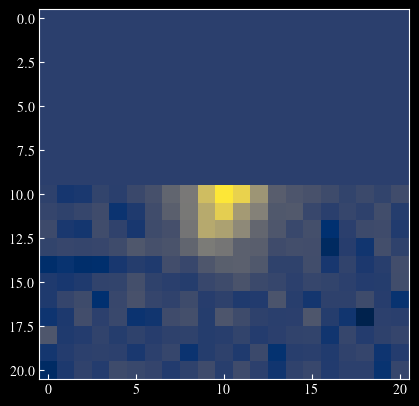

In [4012]:
init_data = obs.data
plt.imshow(obs.data[0], cmap = 'cividis')

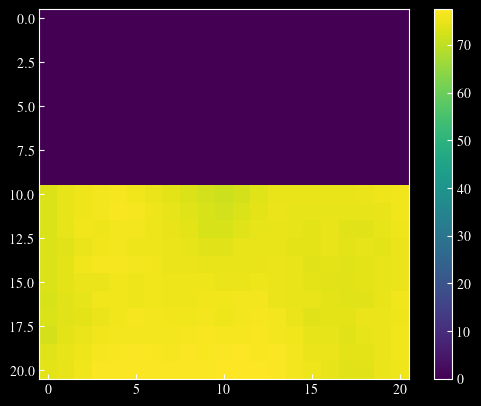

In [4013]:
plt.imshow(obs.weights[0])
plt.colorbar()

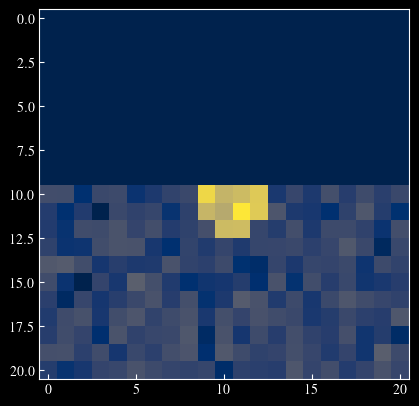

In [4014]:
# define initial circular model for initial morphology estimate 
morph_init = [None]*len(centers)
key = random.split(random.PRNGKey(0), 1)
sigma = .1 # noise factor

for i, bx in enumerate(box_size):
    arr = np.zeros((bx, bx))
    rr, cc = draw.disk((bx/2, bx/2), radius=bx/12, shape=arr.shape)
    arr[rr, cc] = 1
    noise = random.normal(key, (bx, bx))
    raw =  (jnp.array(arr) + sigma * noise)
    normed = (raw-jnp.min(raw))/(jnp.max(raw)-jnp.min(raw))
    morph_init[i] = np.array(normed)
    
# remove lower half of data
for m in range(int(box_size[0] / 2) - 0):
    morph_init[0][m,:] = 0 * morph_init[0][m,:]  

    
plt.imshow(morph_init[0], cmap='cividis')

In [4015]:
# Load up the Scene with constraints and prior selected
keys = random.split(random.PRNGKey(0), 2)
src_num = len( centers )
with Scene(model_frame) as scene:
    for i in range( src_num ):
        Source(
            centers[i],
            ArraySpectrum(random.normal(keys[0], (1,)), constraint=PositiveConstraint()),
            ArrayMorphology(morph_init[i], prior=NNPrior())
        )

In [4016]:
# ------------------ #
# tracking functions #
# ------------------ #
@eqx.filter_value_and_grad
def lik_grad(model, obs):
    sources = model()
    neg_log_like = -obs.log_likelihood(sources)
    return  neg_log_like

@eqx.filter_grad
def lik_grad_2(model):
    sources = model()
    neg_log_like = -obs.log_likelihood(sources)
    return  neg_log_like

@eqx.filter_value_and_grad
def neural_grad(model, weight):
    prior = 0.0
    sources = model()
    for i in range(src_num):
        prior += weight * model.sources[i].morphology.prior.log_prob( model.sources[i].morphology.value )
    return  -prior 

def track_grad(model, obs, weigth):
    loss1, grad_lik    = lik_grad(model, obs)
    loss1, grad_neural = neural_grad(model, weigth)
    return grad_lik, grad_neural

# ------------------ #
# main train routine #
# ------------------ #
@eqx.filter_value_and_grad
def loss_fn_with_grad(model, obs, weight):
    prior = 0.0
    sources = model()
    neg_log_like = -obs.log_likelihood(sources) 
    for i in range(src_num):
        prior += weight * model.sources[i].morphology.prior.log_prob( model.sources[i].morphology.value )
    return  neg_log_like - prior  

def make_step(model, obs, opt_state, weigth):
    loss, grads = loss_fn_with_grad(model, obs, weigth)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, grads, model, opt_state

# hyperparameters for gradient optimiser
learning_rate= 1e-1 # alter this if desired
optim = optax.adam(learning_rate)
opt_state = optim.init(eqx.filter(scene, eqx.is_array))
best_loss = 1e20
iters = 16
weight = 3.5 #3.5 #1.5   # this controls how strong the neural net grads are

# fitting routine
pbar = tqdm(range(iters), desc='fitting sources')
for step in pbar:
    loss, grads, scene, opt_state = make_step(scene, obs, opt_state, weight)
    loss = loss.item()
    pbar.set_description(f" fitting sources ==>  step: {step} loss: {loss}")
    
    # track gradient evolution
    if step == iters -2:
        grad_lik, grad_neural = track_grad(scene, obs, weight)
        test = lik_grad_2(scene)

print(f"final step={step} loss={loss}")

 fitting sources ==>  step: 15 loss: -1210.186279296875: 100%|██████████| 16/16 [00:00<00:00, 23.12it/s] 

final step=15 loss=-1210.186279296875


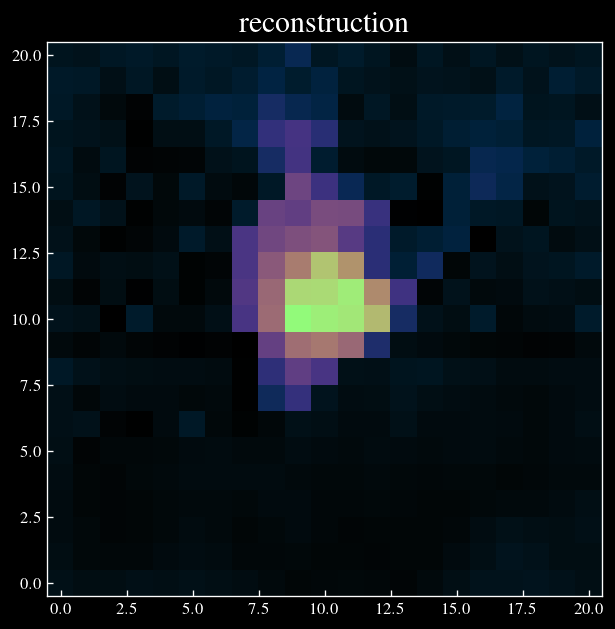

<Figure size 640x480 with 0 Axes>

In [4017]:
# These should look far more like actual galaxies with the neural network acting as a constraint
fig, ax = plt.subplots(1, 1, figsize=(15,6),dpi=120)
y = scene.sources[0].morphology() 
ax.imshow(y, cmap = cmr.lilac)
ax.set_title(f"reconstruction", fontsize = 18)
ax.invert_yaxis()
plt.show()
plt.clf()

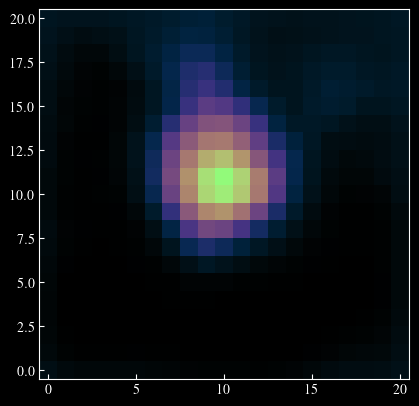

In [4018]:
renders = obs.render(scene())
plt.imshow(renders[0], cmap = cmr.lilac)
plt.gca().invert_yaxis()

In [4019]:
import jax
import jax.numpy as jnp
import jax.random as random
from jax import jvp, grad, jit

# --------------------- #
# Hessian approximation #
# --------------------- #
# https://arxiv.org/pdf/2006.00719.pdf

# for regular functions f
def hvp(f, primals, tangents):
    return jvp(grad(f), primals, tangents)[1]

# for score functions
def hvp_grad(grad_f, primals, tangents):
    return jvp(grad_f, primals, tangents)[1]

# diagonals of Hessian from HVPs
def hvp_rad(hvp, shape):
    max_iters = 4000 # maximum number of iterations
    H = jnp.zeros(shape, dtype=jnp.float32)
    H_ = jnp.zeros(shape, dtype=jnp.float32)
    for i in range(max_iters):
        key = random.PRNGKey(i)
        z = random.rademacher(key, shape , dtype=jnp.float32)
        H += jnp.multiply(z, hvp(z))
        if i > 0:
            norm = jnp.linalg.norm(H/(i+1) - H_/i, ord=2)
            if norm < 1e-6 * jnp.linalg.norm(H/(i+1), ord=2): # gets reasonable results with 1e-2
                break
        H_ = H
    return H/(i+1) 

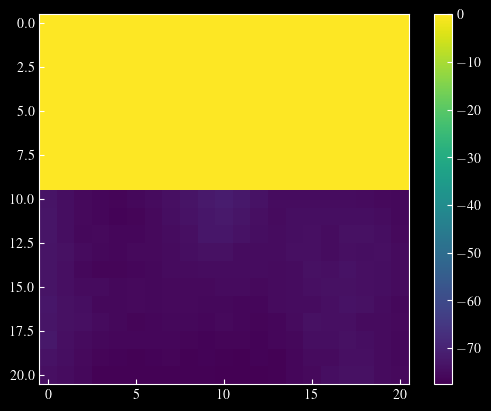

In [4020]:
def log_like(morph, spectrum, data, weights):
    model = morph[None, :, :] * spectrum[:, None, None]
    D = jnp.prod(jnp.asarray(data.shape)) - jnp.sum(weights == 0)
    log_norm = D / 2 * jnp.log(2 * jnp.pi)
    log_like = -jnp.sum(weights * (model - data) ** 2) / 2
    return log_like - log_norm

model_scene = scene()
morph = model_scene[0] 
spectrum = jnp.array((1,))
data = obs.data[0] 
weights = obs.weights[0] 

# jit the HVP for this loss and this morph model
f = lambda morph: log_like(morph, spectrum, data, weights)
jit_hvp_x = jit(lambda z: hvp(f, (morph,), (z,)))
hvp_ll = hvp_rad(jit_hvp_x, morph.shape)
plt.imshow(hvp_ll)
plt.colorbar()

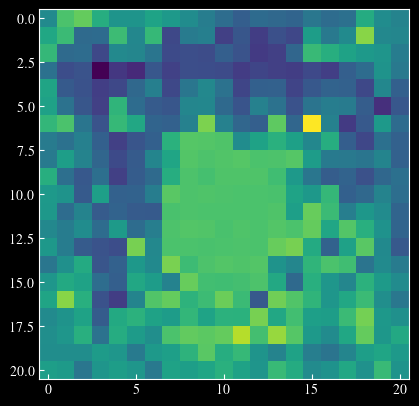

In [4021]:
@jax.grad
def neural_grad(galaxy, weight):
    prior = weight * scene.sources[0].morphology.prior.log_prob( galaxy )
    return prior

#weight = 1
morph = model_scene[0]
f = lambda morph: neural_grad(morph, weight)
jit_hvp_x2 = jit(lambda z: hvp_grad(f, (morph,), (z,)))
hvp_nn = hvp_rad(jit_hvp_x2, morph.shape)
hvp_nn = np.array(hvp_nn)
plt.imshow(hvp_nn)

In [4022]:
# %timeit hvp_rad(jit_hvp_x, morph.shape)
# %timeit hvp_rad(jit_hvp_x2, morph.shape)

In [4023]:
def norm_2d(array):
    "funtion to return the normalised array"
    return (array - np.min(array)) / (np.max(array) - np.min(array))

In [4024]:
# rotate images
init_src = norm_2d(obs.data[0]) * obs.weights[0]
y = scene.sources[0].morphology() 
y = renders[0]
diff = -hvp_nn + hvp_ll
init_src = scipy.ndimage.rotate(init_src, 270)
y = scipy.ndimage.rotate(y, 270)
diff = scipy.ndimage.rotate(diff, 270)
hvp_ll = scipy.ndimage.rotate(hvp_ll, 270)
hvp_nn = scipy.ndimage.rotate(hvp_nn, 270)

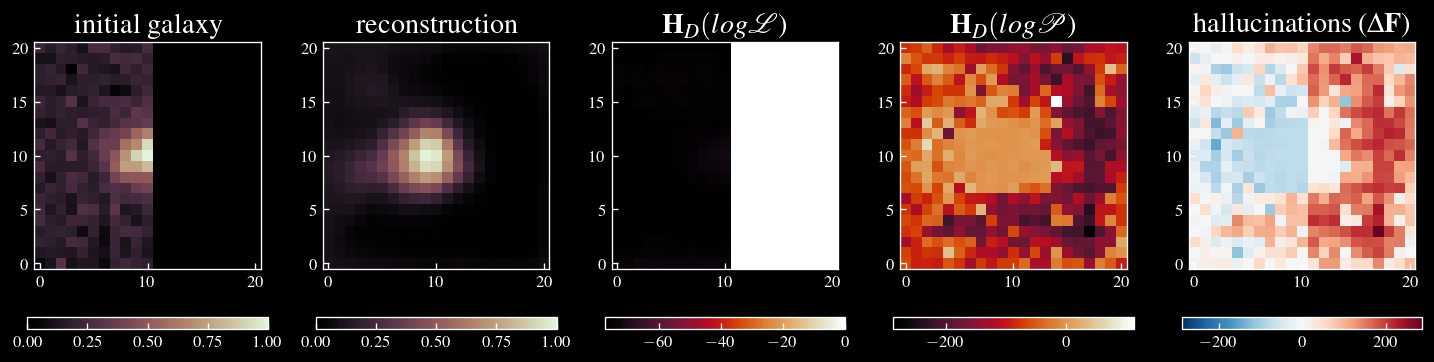

In [4025]:
fig, axes = plt.subplots(1, 5, figsize=(15,3.5),dpi=120)

im4 = axes[0].imshow(norm_2d(init_src), vmin=0, vmax=1, cmap = cmr.sepia)
axes[0].invert_yaxis()
plt.colorbar(im4, ax=axes[0],orientation='horizontal')


im4 = axes[1].imshow(norm_2d(y), vmin=0, vmax=1, cmap = cmr.sepia)
axes[1].invert_yaxis()
plt.colorbar(im4, ax=axes[1],orientation='horizontal')

im2 = axes[2].imshow(hvp_ll, 
                    cmap = cmr.sunburst)
axes[2].invert_yaxis()
plt.colorbar(im2, ax=axes[2],orientation='horizontal')

im1 = axes[3].imshow(hvp_nn, 
                    cmap = cmr.sunburst)
axes[3].invert_yaxis()
plt.colorbar(im1, ax=axes[3],orientation='horizontal')

true_max = np.max(np.abs(diff))
im3 = axes[4].imshow(diff, 
                    cmap = 'RdBu_r', vmin = -true_max, vmax = true_max) 
axes[4].invert_yaxis()
plt.colorbar(im3, ax=axes[4],orientation='horizontal')


axes[0].set_title("initial galaxy", fontsize = 17)
axes[1].set_title("reconstruction", fontsize = 17)
axes[2].set_title(r"$\mathbf{H}_D (log\mathcal{L}$)", fontsize = 17)
axes[3].set_title(r"$\mathbf{H}_D (log\mathcal{P}$)", fontsize = 17)
axes[4].set_title(r"hallucinations ($\Delta \mathbf{F}$)", fontsize = 17)
plt.savefig('hessian_panels_1.png', dpi=250)
plt.show()

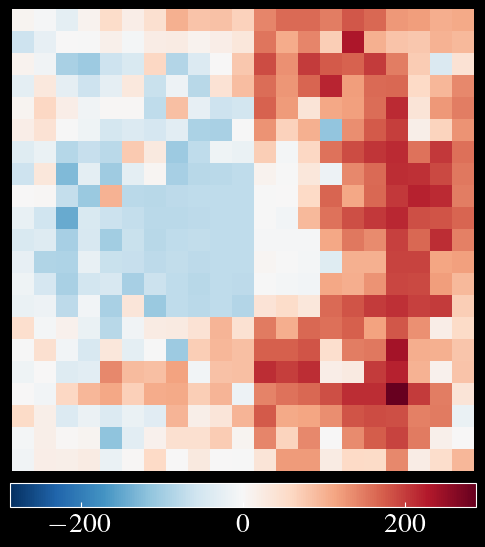

In [4026]:

fig = plt.figure(figsize=(6, 6))
im3 = plt.imshow(diff,vmin = -true_max, vmax = true_max,cmap = 'RdBu_r') 
plt.axis('off')
plt.gca().invert_yaxis()
cbar_ax = fig.add_axes([0.125, 0.05, 0.776, 0.040])
cbar = fig.colorbar(im3, cax=cbar_ax,
            orientation="horizontal")
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)
plt.savefig('score_hessian.pdf', dpi=250)
plt.show()


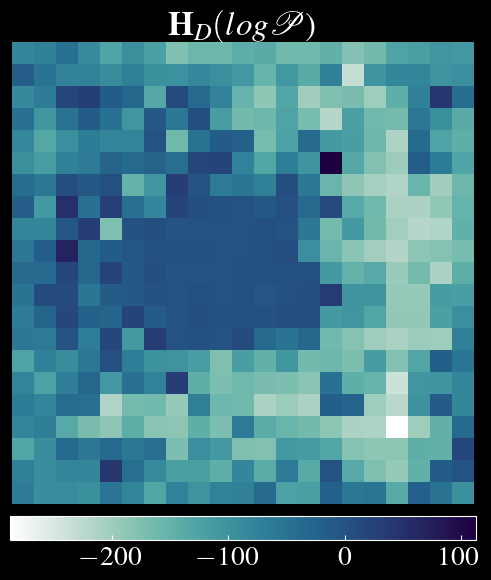

In [4027]:
fig = plt.figure(figsize=(6, 6))
im3 = plt.imshow(hvp_nn,cmap = cmr.ocean_r) 
plt.title(r"$\mathbf{H}_D (log\mathcal{P}$)", fontsize = 24)
plt.axis('off')
plt.gca().invert_yaxis()
cbar_ax = fig.add_axes([0.125, 0.05, 0.776, 0.040])
cbar = fig.colorbar(im3, cax=cbar_ax,
            orientation="horizontal")
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)
plt.savefig("hessian_prior.png", dpi=250)
plt.show()

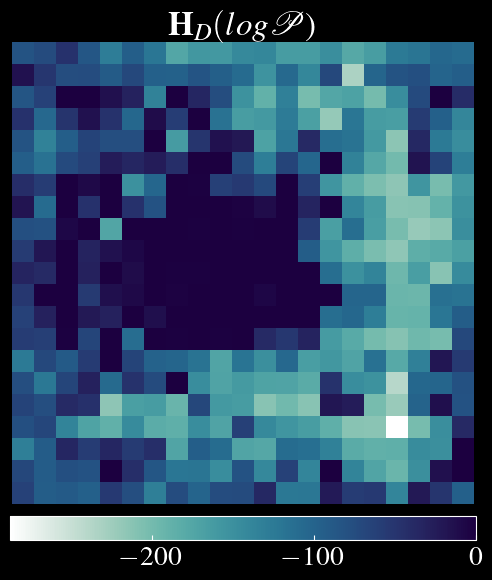

In [4028]:
fig = plt.figure(figsize=(6, 6))
im3 = plt.imshow(hvp_nn,cmap = cmr.ocean_r, vmax=0) 
plt.title(r"$\mathbf{H}_D (log\mathcal{P}$)", fontsize = 24)
plt.axis('off')
plt.gca().invert_yaxis()
cbar_ax = fig.add_axes([0.125, 0.05, 0.776, 0.040])
cbar = fig.colorbar(im3, cax=cbar_ax,
            orientation="horizontal")
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)
plt.savefig("hessian_prior_max0.png", dpi=250)
plt.show()

In [4029]:
positive_pixels = (hvp_nn > 0).sum()
print(f"there are {positive_pixels} positive pixels in the prior hessian out of {hvp_nn.size}")
print(jnp.min(hvp_nn), jnp.max(hvp_nn))

there are 60 positive pixels in the prior hessian out of 441
-287.7188 112.70496


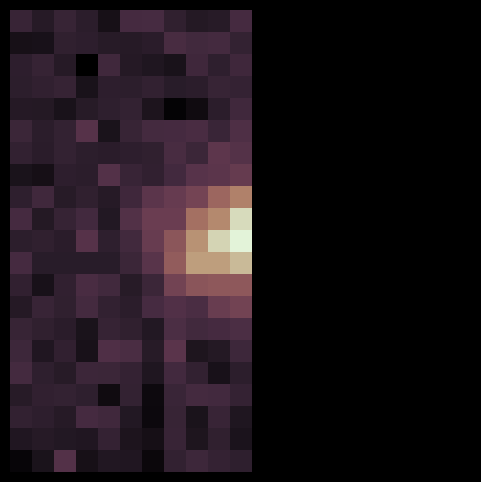

In [4030]:

fig = plt.figure(figsize=(6, 6))
im3 = plt.imshow(init_src,
                    cmap = cmr.sepia, vmin = 0) #, vmax = true_max) 
#plt.invert_yaxis()
#plt.title("HVP (data)", fontsize = 22)
plt.axis('off')
plt.gca().invert_yaxis()
plt.savefig('src_init.pdf', dpi=250)
plt.show()

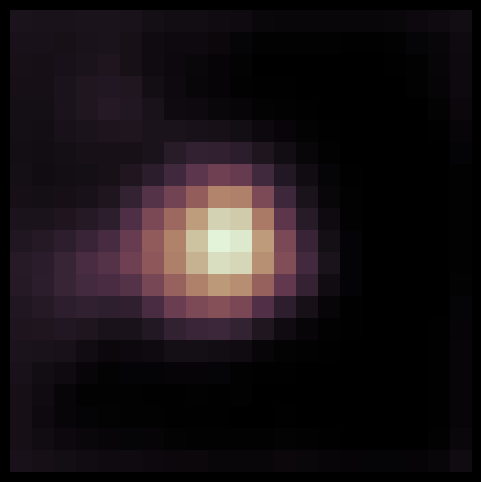

In [4031]:
fig = plt.figure(figsize=(6, 6))
diff = (norm_2d(hvp_ll))
true_max = np.max(np.abs(diff))
im3 = plt.imshow(norm_2d(y),
                    cmap = cmr.sepia, vmin = 0) #, vmax = true_max) 
#plt.invert_yaxis()
#plt.title("HVP (data)", fontsize = 22)
plt.axis('off')
plt.gca().invert_yaxis()
plt.savefig('src_final.pdf', dpi=250)
plt.show()

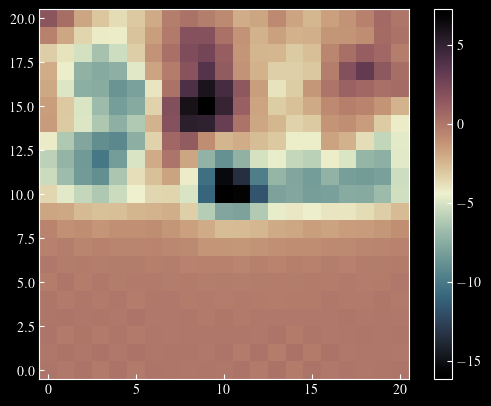

In [4032]:
plt.imshow(grad_lik.sources[0].morphology.value, cmap = cmr.copper)
plt.gca().invert_yaxis()
plt.colorbar()

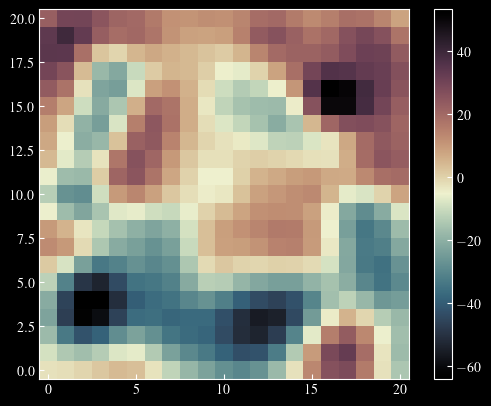

In [4033]:
plt.imshow(grad_neural.sources[0].morphology.value, cmap = cmr.copper)
plt.gca().invert_yaxis()
plt.colorbar()